In [1]:
# FloodNet Data Exploration & Preprocessing
# **Objectives:**
# 1. Explore dataset structure and statistics
# 2. Analyze class distribution
# 3. Visualize sample images and masks
# 4. Set up preprocessing pipeline
# 5. Calculate class weights for handling imbalance

In [2]:
 ## 1. Setup and Imports

# %%
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(" Libraries imported successfully!")

 Libraries imported successfully!


In [5]:
# 2. Configuration
# If config.py exists, import it; otherwise define inline
try:
    from src.utils.config import Config
    print(" Config loaded from file")
except ImportError:
    print(" Config not found, using inline configuration")
    
    class Config:
        # Update this path to match your setup
        BASE_DIR = Path(r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation")
        
        # Data paths
        RAW_DATA = BASE_DIR / "data" / "raw" / "FloodNet"
        TRAIN_IMAGES = RAW_DATA / "train" / "train-org-img"
        TRAIN_MASKS = RAW_DATA / "train" / "train-label-img"
        VAL_IMAGES = RAW_DATA / "val" / "val-org-img"
        VAL_MASKS = RAW_DATA / "val" / "val-label-img"
        TEST_IMAGES = RAW_DATA / "test" / "test-org-img"
        TEST_MASKS = RAW_DATA / "test" / "test-label-img"
        
        # Results
        RESULTS_DIR = BASE_DIR / "results"
        VIZ_DIR = RESULTS_DIR / "visualizations" / "data_exploration"
        
        # Parameters
        IMG_HEIGHT = 256
        IMG_WIDTH = 256
        NUM_CLASSES = 10
        
        # Classes
        CLASSES = {
            0: "Background", 1: "Building-flooded", 2: "Building-non-flooded",
            3: "Road-flooded", 4: "Road-non-flooded", 5: "Water",
            6: "Tree", 7: "Vehicle", 8: "Pool", 9: "Grass"
        }
        
        CLASS_COLORS = {
            0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 0, 255),
            3: (255, 165, 0), 4: (128, 128, 128), 5: (0, 255, 255),
            6: (0, 255, 0), 7: (255, 0, 255), 8: (255, 255, 255), 9: (0, 128, 0)
        }

# Create visualization directory
Config.VIZ_DIR.mkdir(parents=True, exist_ok=True)
print(f"Base Directory: {Config.BASE_DIR}")

 Config not found, using inline configuration
Base Directory: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation


In [6]:
# 3. Dataset Exploration

def count_files(directory):
    """Count files in a directory"""
    if directory.exists():
        files = list(directory.glob("*"))
        return len(files), files
    return 0, []

# Count all files
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

datasets = {
    "Train Images": Config.TRAIN_IMAGES,
    "Train Masks": Config.TRAIN_MASKS,
    "Val Images": Config.VAL_IMAGES,
    "Val Masks": Config.VAL_MASKS,
    "Test Images": Config.TEST_IMAGES,
    "Test Masks": Config.TEST_MASKS,
}

stats = {}
for name, path in datasets.items():
    count, files = count_files(path)
    stats[name] = {"count": count, "path": path, "files": files}
    status = "✅" if count > 0 else "❌"
    print(f"{status} {name}: {count} files")


DATASET STATISTICS
✅ Train Images: 1445 files
✅ Train Masks: 1445 files
✅ Val Images: 450 files
✅ Val Masks: 450 files
✅ Test Images: 448 files
✅ Test Masks: 448 files


In [7]:
# 4. Analyze Image Properties

def analyze_image_properties(image_dir, sample_size=50):
    """Analyze image dimensions and properties"""
    files = list(image_dir.glob("*"))[:sample_size]
    
    dimensions = []
    file_sizes = []
    
    for f in files:
        img = cv2.imread(str(f))
        if img is not None:
            dimensions.append(img.shape)
            file_sizes.append(f.stat().st_size / 1024)  # KB
    
    return dimensions, file_sizes

print("\n" + "=" * 60)
print("IMAGE PROPERTIES ANALYSIS")
print("=" * 60)

if stats["Train Images"]["count"] > 0:
    dims, sizes = analyze_image_properties(Config.TRAIN_IMAGES)
    
    print(f"\nSampled {len(dims)} images:")
    print(f"  Dimensions: {dims[0] if dims else 'N/A'}")
    print(f"  Unique shapes: {len(set(dims))}")
    print(f"  Average file size: {np.mean(sizes):.1f} KB")
    print(f"  Min file size: {np.min(sizes):.1f} KB")
    print(f"  Max file size: {np.max(sizes):.1f} KB")


IMAGE PROPERTIES ANALYSIS

Sampled 50 images:
  Dimensions: (3000, 4000, 3)
  Unique shapes: 2
  Average file size: 5617.9 KB
  Min file size: 4841.8 KB
  Max file size: 7726.3 KB


Sample IMAGE filenames:
   10165.jpg
   10166.jpg
   10168.jpg
   10170.jpg
   10171.jpg

Sample MASK filenames:
   10165_lab.png
   10166_lab.png
   10168_lab.png
   10170_lab.png
   10171_lab.png

Naming Pattern Analysis:
   Image example: 10165.jpg
   Mask example:  10165_lab.png
   Image stem: '10165', ext: '.jpg'
   Mask stem:  '10165_lab', ext: '.png'
    Pattern: Image name + '_lab' suffix

🧪 Testing mask matching:
   10165.jpg → 10165_lab.png ✅
   10166.jpg → 10166_lab.png ✅
   10168.jpg → 10168_lab.png ✅
   10170.jpg → 10170_lab.png ✅
   10171.jpg → 10171_lab.png ✅

FIXED SAMPLE VISUALIZATION
Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\sample_train_images_fixed.png


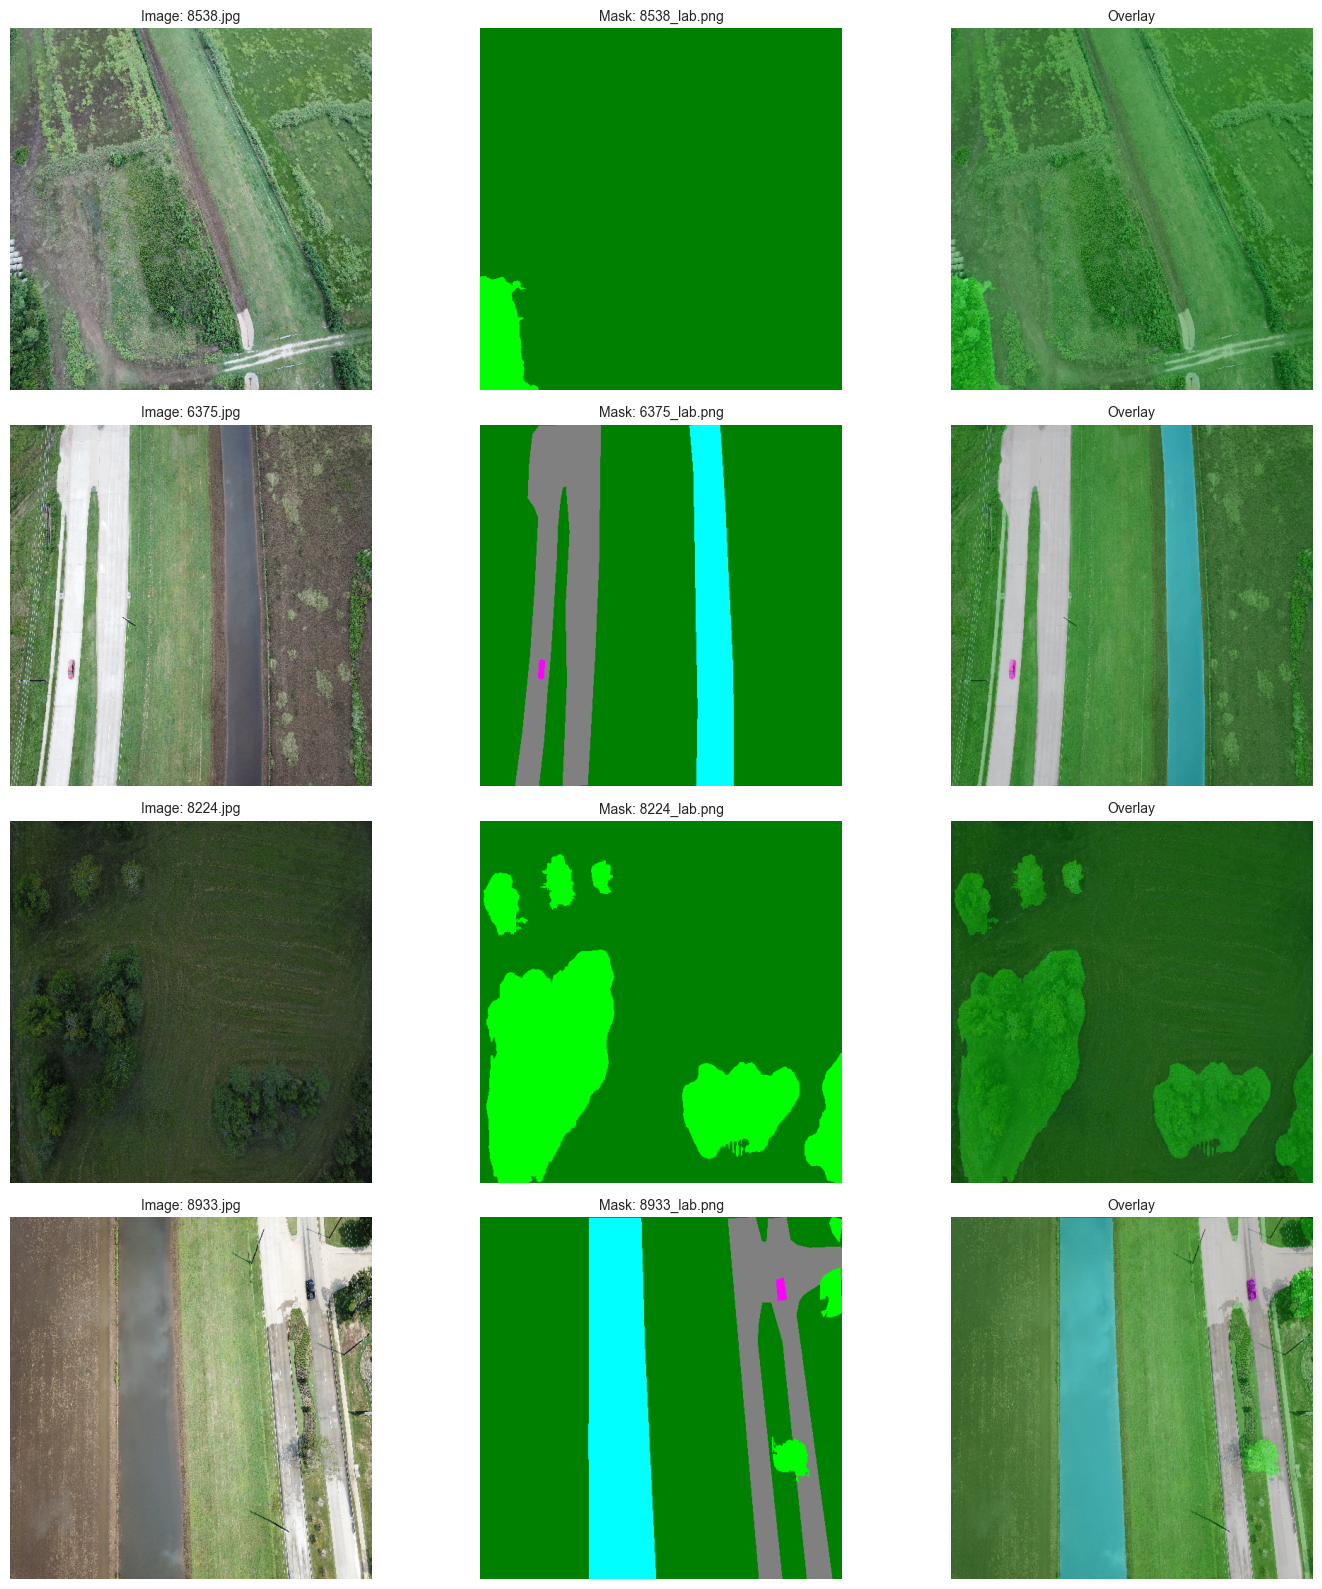


VERIFYING ALL IMAGE-MASK PAIRS

All images have matching masks!

Summary:
   Total images: 1445
   Total masks:  1445
   Missing:      0


In [ ]:
import os
from pathlib import Path

# Paths
train_img_dir = Path(r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\data\raw\FloodNet\train\train-org-img")
train_mask_dir = Path(r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\data\raw\FloodNet\train\train-label-img")

# Get sample filenames
img_files = sorted(list(train_img_dir.glob("*")))[:5]
mask_files = sorted(list(train_mask_dir.glob("*")))[:5]

print("Sample IMAGE filenames:")
for f in img_files:
    print(f"   {f.name}")

print("\nSample MASK filenames:")
for f in mask_files:
    print(f"   {f.name}")

# Detect the naming pattern
def detect_naming_pattern(img_dir, mask_dir):
    """Detect how image and mask files are named"""
    img_files = list(img_dir.glob("*"))
    mask_files = list(mask_dir.glob("*"))
    
    if not img_files or not mask_files:
        return None
    
    img_name = img_files[0].stem  # filename without extension
    img_ext = img_files[0].suffix
    mask_name = mask_files[0].stem
    mask_ext = mask_files[0].suffix
    
    print(f"\nNaming Pattern Analysis:")
    print(f"   Image example: {img_files[0].name}")
    print(f"   Mask example:  {mask_files[0].name}")
    print(f"   Image stem: '{img_name}', ext: '{img_ext}'")
    print(f"   Mask stem:  '{mask_name}', ext: '{mask_ext}'")
    
    # Check common patterns
    if mask_name == img_name:
        pattern = "same_name"
        print(f"    Pattern: Same name, different extension")
    elif mask_name == f"{img_name}_lab":
        pattern = "add_lab_suffix"
        print(f"    Pattern: Image name + '_lab' suffix")
    elif mask_name == f"{img_name}_mask":
        pattern = "add_mask_suffix"
        print(f"    Pattern: Image name + '_mask' suffix")
    elif img_name in mask_name:
        pattern = "contains_name"
        suffix = mask_name.replace(img_name, "")
        print(f"    Pattern: Image name + '{suffix}' suffix")
    else:
        pattern = "unknown"
        print(f"    Pattern: Unknown - manual matching needed")
    
    return pattern

pattern = detect_naming_pattern(train_img_dir, train_mask_dir)

def get_mask_path(image_path, mask_dir):
    """
    Get corresponding mask path for an image.
    Handles multiple naming conventions.
    """
    img_stem = image_path.stem  # filename without extension
    
    # Try different naming patterns
    possible_patterns = [
        f"{img_stem}.png",           # Same name, .png
        f"{img_stem}_lab.png",       # With _lab suffix
        f"{img_stem}_mask.png",      # With _mask suffix
        f"{img_stem}_label.png",     # With _label suffix
        f"{img_stem}.jpg",           # Same name, .jpg
        f"{img_stem}_lab.jpg",       # With _lab suffix, jpg
    ]
    
    for pattern in possible_patterns:
        mask_path = mask_dir / pattern
        if mask_path.exists():
            return mask_path
    
    # If no pattern matches, try to find any file containing the image stem
    for mask_file in mask_dir.glob(f"*{img_stem}*"):
        return mask_file
    
    return None

# Test the function
print("\nTesting mask matching:")
for img_path in img_files[:5]:
    mask_path = get_mask_path(img_path, train_mask_dir)
    status = "✅" if mask_path else "❌"
    mask_name = mask_path.name if mask_path else "NOT FOUND"
    print(f"   {img_path.name} → {mask_name} {status}")

# %%
# Updated visualization function with correct mask matching
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class colors (RGB)
CLASS_COLORS = {
    0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 0, 255),
    3: (255, 165, 0), 4: (128, 128, 128), 5: (0, 255, 255),
    6: (0, 255, 0), 7: (255, 0, 255), 8: (255, 255, 255), 9: (0, 128, 0)
}

def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_mask(path):
    return cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)

def colorize_mask(mask):
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        colored[mask == class_id] = color
    return colored

def visualize_samples_fixed(image_dir, mask_dir, num_samples=4, save_path=None):
    """Visualize samples with correct mask matching"""
    image_files = sorted(list(image_dir.glob("*")))
    
    # Random selection
    indices = np.random.choice(len(image_files), min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    
    for i, idx in enumerate(indices):
        img_path = image_files[idx]
        mask_path = get_mask_path(img_path, mask_dir)
        
        # Load and resize image for display
        img = load_image(img_path)
        img_resized = cv2.resize(img, (512, 512))
        
        # Original image
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title(f"Image: {img_path.name}", fontsize=10)
        axes[i, 0].axis('off')
        
        if mask_path and mask_path.exists():
            mask = load_mask(mask_path)
            mask_resized = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
            colored_mask = colorize_mask(mask_resized)
            
            # Mask
            axes[i, 1].imshow(colored_mask)
            axes[i, 1].set_title(f"Mask: {mask_path.name}", fontsize=10)
            axes[i, 1].axis('off')
            
            # Overlay
            overlay = cv2.addWeighted(img_resized, 0.6, colored_mask, 0.4, 0)
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title("Overlay", fontsize=10)
            axes[i, 2].axis('off')
        else:
            axes[i, 1].text(0.5, 0.5, f"Mask not found\nTried: {img_path.stem}_lab.png", 
                          ha='center', va='center', fontsize=10)
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()

# Run the fixed visualization
print("\n" + "="*60)
print("FIXED SAMPLE VISUALIZATION")
print("="*60)

results_dir = Path(r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration")
visualize_samples_fixed(
    train_img_dir,
    train_mask_dir,
    num_samples=4,
    save_path=results_dir / "sample_train_images_fixed.png"
)

# Verify all images have matching masks
print("\n" + "="*60)
print("VERIFYING ALL IMAGE-MASK PAIRS")
print("="*60)

missing_masks = []
for img_path in train_img_dir.glob("*"):
    mask_path = get_mask_path(img_path, train_mask_dir)
    if not mask_path:
        missing_masks.append(img_path.name)

if missing_masks:
    print(f"\nFound {len(missing_masks)} images without masks:")
    for m in missing_masks[:10]:
        print(f"   - {m}")
    if len(missing_masks) > 10:
        print(f"   ... and {len(missing_masks) - 10} more")
else:
    print("\nAll images have matching masks!")

print(f"\nSummary:")
print(f"   Total images: {len(list(train_img_dir.glob('*')))}")
print(f"   Total masks:  {len(list(train_mask_dir.glob('*')))}")
print(f"   Missing:      {len(missing_masks)}")

In [9]:
# 6. Class Distribution Analysis

def analyze_class_distribution(mask_dir, num_samples=None):
    """Analyze pixel-wise class distribution"""
    mask_files = sorted(list(mask_dir.glob("*")))
    
    if num_samples:
        mask_files = mask_files[:num_samples]
    
    class_pixels = Counter()
    total_pixels = 0
    
    print(f"Analyzing {len(mask_files)} masks...")
    
    for mask_path in tqdm(mask_files, desc="Processing masks"):
        mask = load_mask(mask_path)
        if mask is not None:
            unique, counts = np.unique(mask, return_counts=True)
            for cls, count in zip(unique, counts):
                class_pixels[cls] += count
                total_pixels += count
    
    return class_pixels, total_pixels

# Analyze full training set (or sample if too large)
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

class_pixels, total_pixels = analyze_class_distribution(Config.TRAIN_MASKS)

# Create DataFrame for analysis
distribution_data = []
for cls_id in range(Config.NUM_CLASSES):
    count = class_pixels.get(cls_id, 0)
    percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0
    distribution_data.append({
        "Class ID": cls_id,
        "Class Name": Config.CLASSES[cls_id],
        "Pixel Count": count,
        "Percentage": percentage
    })

df_distribution = pd.DataFrame(distribution_data)
print("\n")
print(df_distribution.to_string(index=False))

# Save to CSV
df_distribution.to_csv(Config.RESULTS_DIR / "metrics" / "class_distribution.csv", index=False)
print(f"\n Saved to: {Config.RESULTS_DIR / 'metrics' / 'class_distribution.csv'}")



CLASS DISTRIBUTION ANALYSIS
Analyzing 1445 masks...


Processing masks: 100%|██████████| 1445/1445 [03:17<00:00,  7.32it/s]



 Class ID           Class Name  Pixel Count  Percentage
        0           Background    308842999    1.735352
        1     Building-flooded    318505750    1.789646
        2 Building-non-flooded    572544673    3.217060
        3         Road-flooded    559209008    3.142129
        4     Road-non-flooded    966381628    5.429984
        5                Water   1979142780   11.120568
        6                 Tree   3107988573   17.463418
        7              Vehicle     32624508    0.183313
        8                 Pool     36997059    0.207882
        9                Grass   9914900430   55.710647

 Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\metrics\class_distribution.csv


Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_distribution.png


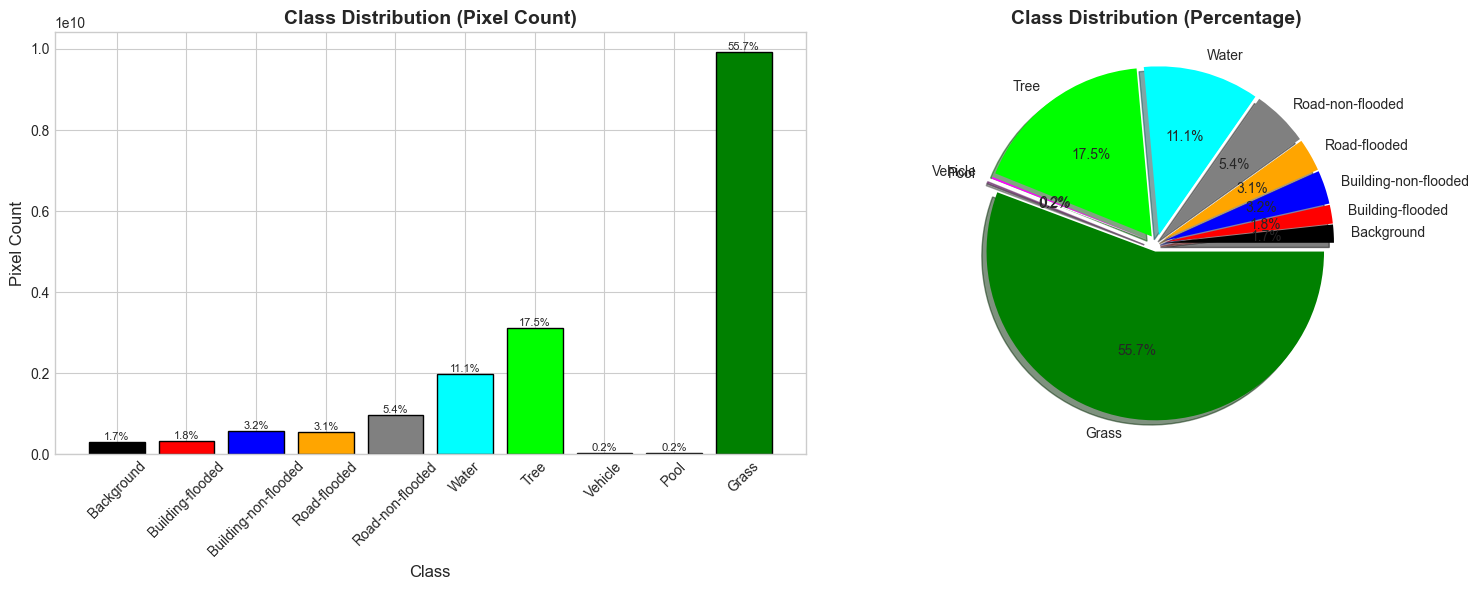

In [10]:
# 7. Visualize Class Distribution

def plot_class_distribution(df, save_path=None):
    """Plot class distribution bar chart"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart - Pixel counts
    colors = [np.array(Config.CLASS_COLORS[i])/255 for i in range(Config.NUM_CLASSES)]
    bars = axes[0].bar(df["Class Name"], df["Pixel Count"], color=colors, edgecolor='black')
    axes[0].set_xlabel("Class", fontsize=12)
    axes[0].set_ylabel("Pixel Count", fontsize=12)
    axes[0].set_title("Class Distribution (Pixel Count)", fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, pct in zip(bars, df["Percentage"]):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Pie chart - Percentages
    explode = [0.05] * Config.NUM_CLASSES
    axes[1].pie(df["Percentage"], labels=df["Class Name"], autopct='%1.1f%%',
                colors=colors, explode=explode, shadow=True)
    axes[1].set_title("Class Distribution (Percentage)", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()

plot_class_distribution(
    df_distribution, 
    save_path=Config.VIZ_DIR / "class_distribution.png"
)

In [11]:
# 8. Calculate Class Weights

def calculate_class_weights(class_pixels, total_pixels, method='balanced'):
    """
    Calculate class weights for handling imbalance
    
    Methods:
    - 'balanced': Inverse frequency
    - 'effective': Effective number of samples
    """
    weights = {}
    num_classes = Config.NUM_CLASSES
    
    if method == 'balanced':
        for cls in range(num_classes):
            count = class_pixels.get(cls, 1)
            weights[cls] = total_pixels / (num_classes * count)
    
    elif method == 'effective':
        beta = 0.9999
        for cls in range(num_classes):
            count = class_pixels.get(cls, 1)
            effective_num = 1.0 - np.power(beta, count)
            weights[cls] = (1.0 - beta) / effective_num
    
    # Normalize
    max_weight = max(weights.values())
    weights = {k: v/max_weight for k, v in weights.items()}
    
    return weights

# Calculate weights
print("\n" + "=" * 60)
print("CLASS WEIGHTS (for handling imbalance)")
print("=" * 60)

balanced_weights = calculate_class_weights(class_pixels, total_pixels, 'balanced')
effective_weights = calculate_class_weights(class_pixels, total_pixels, 'effective')

print("\nBalanced Weights:")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASSES[cls]}): {balanced_weights[cls]:.4f}")

print("\nEffective Number Weights (recommended for severe imbalance):")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASSES[cls]}): {effective_weights[cls]:.4f}")

# Save weights
import json
weights_data = {
    "balanced": balanced_weights,
    "effective": effective_weights
}
with open(Config.RESULTS_DIR / "metrics" / "class_weights.json", 'w') as f:
    json.dump(weights_data, f, indent=2)
print(f"\nSaved to: {Config.RESULTS_DIR / 'metrics' / 'class_weights.json'}")



CLASS WEIGHTS (for handling imbalance)

Balanced Weights:
  Class 0 (Background): 0.1056
  Class 1 (Building-flooded): 0.1024
  Class 2 (Building-non-flooded): 0.0570
  Class 3 (Road-flooded): 0.0583
  Class 4 (Road-non-flooded): 0.0338
  Class 5 (Water): 0.0165
  Class 6 (Tree): 0.0105
  Class 7 (Vehicle): 1.0000
  Class 8 (Pool): 0.8818
  Class 9 (Grass): 0.0033

Effective Number Weights (recommended for severe imbalance):
  Class 0 (Background): 1.0000
  Class 1 (Building-flooded): 1.0000
  Class 2 (Building-non-flooded): 1.0000
  Class 3 (Road-flooded): 1.0000
  Class 4 (Road-non-flooded): 1.0000
  Class 5 (Water): 1.0000
  Class 6 (Tree): 1.0000
  Class 7 (Vehicle): 1.0000
  Class 8 (Pool): 1.0000
  Class 9 (Grass): 1.0000

Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\metrics\class_weights.json


Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_legend.png


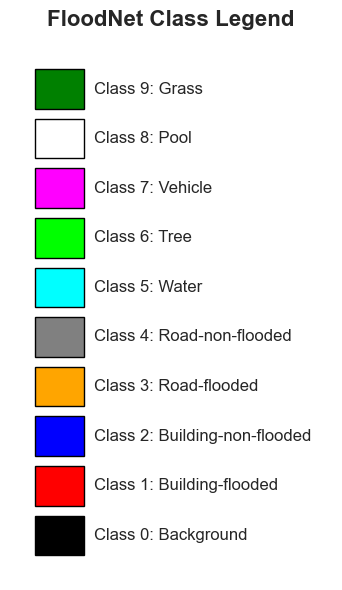

In [12]:
# 9. Create Class Legend

def create_class_legend(save_path=None):
    """Create a visual legend for all classes"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, (cls_id, cls_name) in enumerate(Config.CLASSES.items()):
        color = np.array(Config.CLASS_COLORS[cls_id]) / 255
        rect = plt.Rectangle((0, i), 1, 0.8, color=color, ec='black')
        ax.add_patch(rect)
        ax.text(1.2, i + 0.4, f"Class {cls_id}: {cls_name}", 
                va='center', fontsize=12)
    
    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-0.5, Config.NUM_CLASSES + 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("FloodNet Class Legend", fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()

create_class_legend(save_path=Config.VIZ_DIR / "class_legend.png")

In [13]:
# 10. Summary Statistics

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"""
Dataset Overview:
├── Training Set:   {stats['Train Images']['count']} images
├── Validation Set: {stats['Val Images']['count']} images
└── Test Set:       {stats['Test Images']['count']} images

Image Properties:
├── Original Size:  {dims[0] if dims else 'N/A'}
├── Target Size:    {Config.IMG_HEIGHT} x {Config.IMG_WIDTH}
└── Channels:       RGB (3)

Class Information:
├── Number of Classes: {Config.NUM_CLASSES}
├── Most Common:       {df_distribution.loc[df_distribution['Percentage'].idxmax(), 'Class Name']} ({df_distribution['Percentage'].max():.1f}%)
└── Least Common:      {df_distribution.loc[df_distribution['Percentage'].idxmin(), 'Class Name']} ({df_distribution['Percentage'].min():.2f}%)

   Class Imbalance Detected!
   → Use Focal Loss or weighted Cross-Entropy
   → Apply data augmentation
   → Monitor per-class IoU during training

Output Files:
├── {Config.VIZ_DIR / 'sample_train_images.png'}
├── {Config.VIZ_DIR / 'class_distribution.png'}
├── {Config.VIZ_DIR / 'class_legend.png'}
├── {Config.RESULTS_DIR / 'metrics' / 'class_distribution.csv'}
└── {Config.RESULTS_DIR / 'metrics' / 'class_weights.json'}
""")

print("\n Data Exploration Complete! Ready for model training.")
print("Next Step: Run notebook 02_train_unet_basic.ipynb")


SUMMARY

Dataset Overview:
├── Training Set:   1445 images
├── Validation Set: 450 images
└── Test Set:       448 images

Image Properties:
├── Original Size:  (3000, 4000, 3)
├── Target Size:    256 x 256
└── Channels:       RGB (3)

Class Information:
├── Number of Classes: 10
├── Most Common:       Grass (55.7%)
└── Least Common:      Vehicle (0.18%)

   Class Imbalance Detected!
   → Use Focal Loss or weighted Cross-Entropy
   → Apply data augmentation
   → Monitor per-class IoU during training

Output Files:
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\sample_train_images.png
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_distribution.png
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_legend.png
├── D:\Projects\Image Segmentation for Disaster Resil